In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% }</style>"))

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import numba
from tqdm.notebook import tqdm
from numba import jit, njit
from modulefile import xyz_writer, make_whole, sort_traj, map_index, read_aimd_pimd_xyz_faster, pickle_object, unpickle_object 
from numba.typed import List
from scipy import signal
import pickle

In [14]:
import matplotlib.pyplot as plt

**Steps**: 

- In essence, dynamic structure factor $S(\vec{Q}, \omega)$ is Fourier inverted correlation function of $ F(\vec{Q}, t) = \frac{1}{N} \sum^{N}_{i=1} \sum^{N}_{j=1}<e^{i\vec{Q}.\vec{r}_i(t)}e^{i\vec{Q}.\vec{r}_j(0)}>$ <br> 
- So question is How to find the intermediate scattering function, $ F(\vec{Q}, t) $ as in how to select $\vec{Q}$ values?  

In [3]:
def uniform_random_rotation(x):
    """Apply a random rotation in 3D, with a distribution uniform over the
    sphere.

    Arguments:
        x: vector or set of vectors with dimension (n, 3), where n is the
            number of vectors

    Returns:
        Array of shape (n, 3) containing the randomly rotated vectors of x,
        about the mean coordinate of x.

    Algorithm taken from "Fast Random Rotation Matrices" (James Avro, 1992):
    https://doi.org/10.1016/B978-0-08-050755-2.50034-8
    """

    def generate_random_z_axis_rotation():
        """Generate random rotation matrix about the z axis."""
        R = np.eye(3)
        x1 = np.random.rand()
        R[0, 0] = R[1, 1] = np.cos(2 * np.pi * x1)
        R[0, 1] = -np.sin(2 * np.pi * x1)
        R[1, 0] = np.sin(2 * np.pi * x1)
        return R

    # There are two random variables in [0, 1) here (naming is same as paper)
    x2 = 2 * np.pi * np.random.rand()
    x3 = np.random.rand()

    # Rotation of all points around x axis using matrix
    R = generate_random_z_axis_rotation()
    v = np.array([
        np.cos(x2) * np.sqrt(x3),
        np.sin(x2) * np.sqrt(x3),
        np.sqrt(1 - x3)
    ])
    H = np.eye(3) - (2 * np.outer(v, v))
    M = -(H @ R)
    x = x.reshape((-1, 3))
    mean_coord = np.mean(x, axis=0)
    return ((x - mean_coord) @ M) + mean_coord @ M

In [4]:
#@jit(nopython=True)
def get_k_vectors(min_box_length, n_components=100, delta_k=0.1):
    """
    Will compute the grid of kx, ky and kz wavevectors. 
    """
    k_min = (2*np.pi)/ (min_box_length/2)
    k_max = 20  
    nbins = int((k_max - k_min) // delta_k)
    total_k = np.linspace(k_min, k_max, nbins)
    all_k = np.zeros((n_components*len(total_k), 3))
    #total_k_sq = total_k*total_k
    count = 0
    for k_value in total_k:
        for index in range(n_components):
            if (index == 0): 
                vec = np.array([k_value, 0, 0])
                #all_k[count] = vec
                #count += 1
            vec = uniform_random_rotation(vec)
            all_k[count] = vec
            count += 1
    return all_k

In [5]:
test_k = get_k_vectors(7.5)

In [6]:
traj, natoms = read_aimd_pimd_xyz_faster("traj-5000.xyz")

Reading File traj-5000.xyz


  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
def Sk(traj, natoms, k_vectors, box=[7.5, 7.5, 7.5] ):
    box = np.array(box)
    nframes = len(traj) 
    exp_as_a_function_of_k = np.zeros(len(k_vectors), dtype=np.complex64)
    for index_vec_k, vec_k in enumerate(tqdm(k_vectors)):
        exp_t = 0
        for time in traj:
            frame = traj[time].copy(deep=True)
            frame_xyz = frame[['x', 'y', 'z']].to_numpy()        
            exp_r_k_sum = compute_sk(frame_xyz, box, vec_k)
            exp_t += exp_r_k_sum
        exp_as_a_function_of_k[index_vec_k] = exp_t
    exp_norm = exp_as_a_function_of_k / (natoms*nframes)
    return exp_norm

In [9]:
@jit(nopython=True)
def compute_sk(xyz_pos, box, vec_k): 
    exp_r_k_sum = 0
    for atom1 in xyz_pos[:-1]:
        for atom2 in xyz_pos[1:]:
            d_ij = (atom2 - atom1)
            r_ij = d_ij - (box * np.round((d_ij)/box, 0, np.zeros_like(d_ij)))
            r_k_dot = np.dot(r_ij, vec_k)
            exp_r_k = np.exp(complex(0, -r_k_dot))
            exp_r_k_sum += exp_r_k
    return exp_r_k_sum

In [10]:
test_sk = Sk(traj, natoms, test_k, box=[7.5, 7.5, 7.5])

  0%|          | 0/18300 [00:00<?, ?it/s]

ValueError: x and y must have same first dimension, but have shapes (2035,) and (183,)

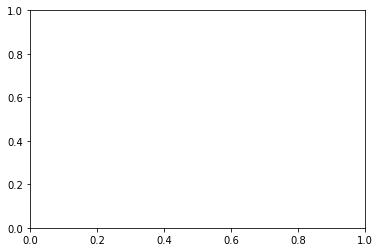

In [37]:
plt.plot(np.linspace(, k_max, nbins), sk_norm[:], '--')

In [41]:
(np.linalg.norm(test_k, axis=1))

array([ 1.67551608,  1.67551608,  1.67551608, ..., 20.        ,
       20.        , 20.        ])

In [35]:
sk_norm = np.sum(np.split(np.abs(test_sk)[:], 183), axis=1)/100

In [ ]:
for i in range(200):
    vec = uniform_random_rotation(np.array([1, 0, 0]))
    print(vec, np.linalg.norm(vec))